# Description

TODO

# Modules

In [1]:
import pandas as pd
import numpy as np

# from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.preprocessing import minmax_scale

from clustermatch import conf

# from clustermatch.coef import cm

# Settings

In [2]:
DATASET_CONFIG = conf.GTEX
GTEX_TISSUE = "whole_blood"
GENE_SEL_STRATEGY = "var_pc_log2"

# Paths

In [3]:
assert (
    conf.MANUSCRIPT["BASE_DIR"] is not None and conf.MANUSCRIPT["BASE_DIR"].exists()
), "Manuscript dir not set"

In [4]:
OUTPUT_FIGURE_DIR = conf.MANUSCRIPT["FIGURES_DIR"] / "coefs_comp"
OUTPUT_FIGURE_DIR.mkdir(parents=True, exist_ok=True)
display(OUTPUT_FIGURE_DIR)

PosixPath('/opt/manuscript/content/images/coefs_comp')

In [5]:
INPUT_CORR_FILE_TEMPLATE = (
    DATASET_CONFIG["SIMILARITY_MATRICES_DIR"]
    / DATASET_CONFIG["SIMILARITY_MATRIX_FILENAME_TEMPLATE"]
)
display(INPUT_CORR_FILE_TEMPLATE)

PosixPath('/opt/data/results/gtex_v8/similarity_matrices/gtex_v8_data_{tissue}-{gene_sel_strategy}-{corr_method}.pkl')

In [6]:
INPUT_FILE = DATASET_CONFIG["SIMILARITY_MATRICES_DIR"] / str(
    INPUT_CORR_FILE_TEMPLATE
).format(
    tissue=GTEX_TISSUE,
    gene_sel_strategy=GENE_SEL_STRATEGY,
    corr_method="all",
)
display(INPUT_FILE)

assert INPUT_FILE.exists()

PosixPath('/opt/data/results/gtex_v8/similarity_matrices/gtex_v8_data_whole_blood-var_pc_log2-all.pkl')

# Data

In [7]:
df = pd.read_pickle(INPUT_FILE)

In [8]:
df.shape

(12497500, 3)

In [9]:
df.head()

clustermatch   pearson  spearman
ENSG00000135245.9  ENSG00000169429.10      0.780181  0.571672  0.853836
ENSG00000163631.16 ENSG00000169429.10      0.401717  0.126906  0.709240
                   ENSG00000135245.9       0.429092  0.110612  0.675719
ENSG00000277632.1  ENSG00000169429.10      0.789583  0.456538  0.850371
                   ENSG00000135245.9       0.780181  0.438929  0.834496

# QQ-plot

In [10]:
QUANTILES = np.linspace(0, 1, 10000)
display(QUANTILES[:10])
display(QUANTILES[-10:])

array([0.        , 0.00010001, 0.00020002, 0.00030003, 0.00040004,
       0.00050005, 0.00060006, 0.00070007, 0.00080008, 0.00090009])

array([0.99909991, 0.99919992, 0.99929993, 0.99939994, 0.99949995,
       0.99959996, 0.99969997, 0.99979998, 0.99989999, 1.        ])

In [11]:
quantiles_df = pd.DataFrame(
    {
        "clustermatch": df["clustermatch"].quantile(QUANTILES).to_numpy(),
        "pearson": df["pearson"].quantile(QUANTILES).to_numpy(),
        "spearman": df["spearman"].quantile(QUANTILES).to_numpy(),
    }
)

In [12]:
quantiles_df.shape

(10000, 3)

In [13]:
quantiles_df.head()

,clustermatch,pearson,spearman
0,-0.001002,1.507747e-08,1.394156e-08
1,0.000451,3.439737e-05,6.005936e-05
2,0.000740,6.698865e-05,1.230900e-04
3,0.000919,1.013318e-04,1.853158e-04
4,0.001064,1.359688e-04,2.469559e-04


In [14]:
quantiles_df.describe()

,clustermatch,pearson,spearman
count,10000.000000,1.000000e+04,1.000000e+04
mean,0.140816,3.055478e-01,3.944529e-01
std,0.144947,2.433592e-01,2.595820e-01
min,-0.001002,1.507747e-08,1.394156e-08
25%,0.028408,9.442383e-02,1.629752e-01
50%,0.081110,2.388598e-01,3.675590e-01
75%,0.216449,4.953855e-01,6.148974e-01
max,0.916918,9.948780e-01,9.867424e-01


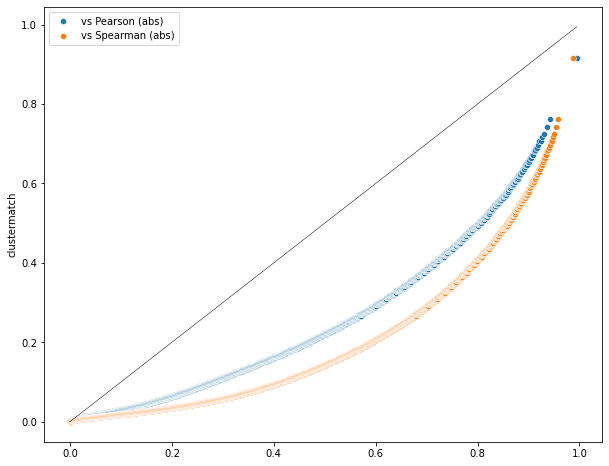

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.scatterplot(
    data=quantiles_df,
    x="pearson",
    y="clustermatch",
    label="vs Pearson (abs)",
    ax=ax,
)

sns.scatterplot(
    data=quantiles_df,
    x="spearman",
    y="clustermatch",
    label="vs Spearman (abs)",
    ax=ax,
)

ax.set_xlabel(None)
# if "_k2" in "clustermatch:
# ax.set_ylabel("clustermatch (linear)")

min_val = min((quantiles_df.iloc[:, 0].min(), quantiles_df.iloc[:, 1].min()))
max_val = max((quantiles_df.iloc[:, 0].max(), quantiles_df.iloc[:, 1].max()))
ax.plot([min_val, max_val], [min_val, max_val], "k", linewidth=0.5)

# ax.set_title(f"{ENRICH_FUNC} ({PERFORMANCE_MEASURE})")

Pearson/Spearman values seem to be more variable in the range (0, 1) than clustermatch

# Density plot

/opt/conda/envs/clustermatch_gene_expr/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


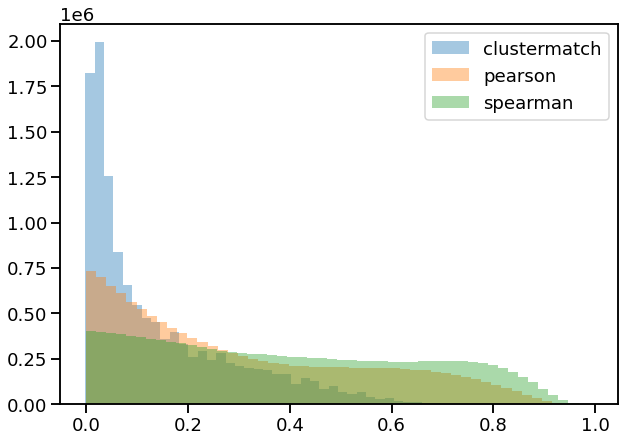

In [16]:
with sns.plotting_context("talk", font_scale=1.1):
    fig, ax = plt.subplots(figsize=(10, 7))

    for method in [x for x in df.columns if not x.endswith("_std")]:
        sns.distplot(x=df[method], hist=True, kde=False, label=method, ax=ax)

    plt.legend()

The distributions are very different. Clustermatch is skewed to the left, whereas pearson and (specially) spearman seem more uniform.

## Joint plots comparing each coefficient

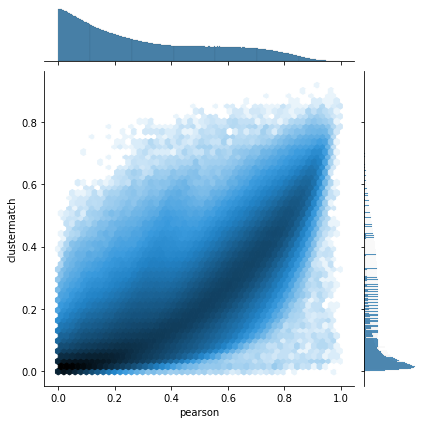

In [17]:
sns.jointplot(
    data=df,
    x="pearson",
    y="clustermatch",
    kind="hex",
    bins="log",
)

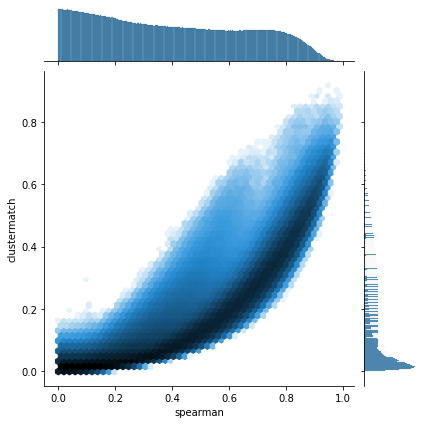

In [18]:
sns.jointplot(
    data=df,
    x="spearman",
    y="clustermatch",
    kind="hex",
    bins="log",
)

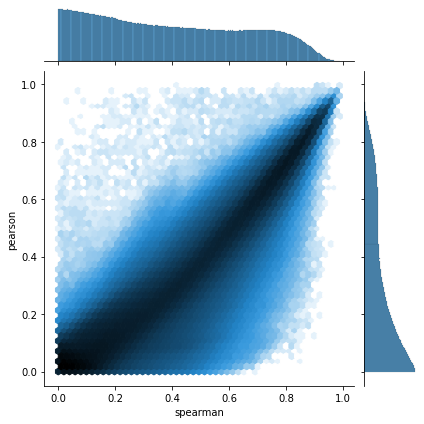

In [19]:
sns.jointplot(
    data=df,
    x="spearman",
    y="pearson",
    kind="hex",
    bins="log",
)

## Correlations between coefficient values

In [20]:
df.corr()

,clustermatch,pearson,spearman
clustermatch,1.000000,0.880495,0.904513
pearson,0.880495,1.000000,0.933254
spearman,0.904513,0.933254,1.000000


In [21]:
df.corr("spearman")

,clustermatch,pearson,spearman
clustermatch,1.000000,0.870081,0.943202
pearson,0.870081,1.000000,0.918524
spearman,0.943202,0.918524,1.000000
